# 🪄💪🥸📰 Ayudando a luchar contra la desinformación, utilizando un Modelo Predictivo entrenado con noticias de meneame.net

[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/javichur/meneame-nlp/blob/main/meneame-nlp-desinformacion.ipynb)

*\#NLP #Transformers #RoBERTa #AWS #Intel #Hackathon #hackathoniberia*

by [@javichur](https://github.com/javichur) (https://javiercampos.es)

## ❓ Problema que se quiere resolver

La desinformación (o *fake news*) es la información errónea que se da, generalmente de manera intencionada.

Esta desinformación perjudica frecuentemente a **colectivos desfavorecidos**, como inmigrantes, refugiados, pobres, niños, adolescentes, ancianos, mujeres víctimas de violencia de género, personas con discapacidad...

## 🏋️‍♀️ Impacto Social

- Las noticias falsas se ensañan con los **refugiados**: https://www.cear.es/noticias-falsas-refugiados/

- Según un estudio de la UC3M, La mitad de los **estudiantes de ESO** no distingue las “fake news”: https://www.uc3m.es/ss/Satellite/UC3MInstitucional/es/Detalle/Comunicacion_C/1371320130990/1371215537949/La_mitad_de_los_estudiantes_de_ESO_no_distingue_las_%E2%80%9Cfake_news%E2%80%9D

- El 86% de la **población española** se cree las noticias falsas, pese a que el 60% cree que sabe detectarlas: https://www.simplelogica.com/wp-content/uploads/2018/10/estudiopescanova.pdf

- **Una de cada cuatro jóvenes** se sienten físicamente inseguras por culpa de la desinformación: https://www.rtve.es/noticias/20211004/informe-desinformacion-mujeres-jovenes-salud-mental-participacion/2179620.shtml


## 💡 Solución propuesta

Nuestro objetivo es, a partir de una secuencia de entrada (ejemplo: el título de una noticia), ayudar a identificar si es potencialmente:

- a) 🥸 Desinformación,
- b) ⚠️ Una noticia relevante,
- c) 💤 Una noticia no interesante.

Para ello, primero generaremos un Dataset de noticias de Meneame.net, las cuales están accesibles de forma pública a través de internet. Meneame.net es un portal donde los usuarios envían noticias y los usuarios votan las más interesantes (con "meneos" positivos o votos negativos).

En Meneame.net hay casi 4 Millones de noticias, cada una de las cuales puede estar en 1 de estos estados:

- **"Publicada"**, es una noticia que ha recibido muchos votos positivos y pocos votos negativos en proporción, por tanto se considera una noticia con probabilidad muy alta de ser veraz y relevante. Un ejemplo:

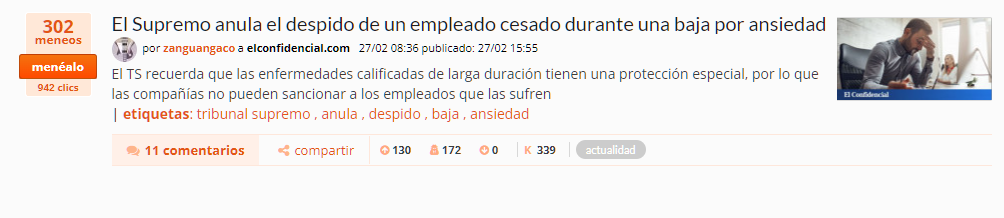

- **"Descartada"**: es una noticia que ha recibido muchos votos negativos y ya no aparece en la web ni puede recibir más votos. Suele ser una noticia falsa, clickbait (que solo busca el click) o duplicada. Un ejemplo:

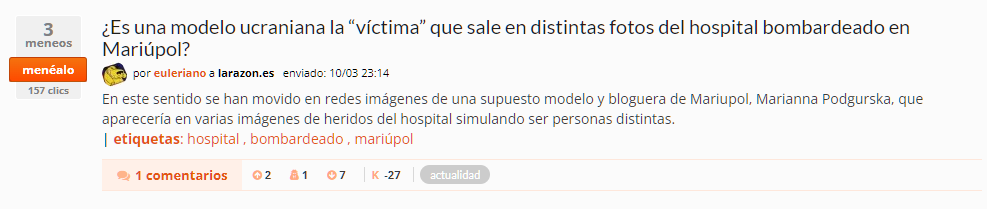

- **Encolada (pendiente de publicarse en portada)**: es una noticia que aún no ha sido publicada en la portada porque no ha recibido suficientes votos positivos en comparación con el nº de votos negativos. En este estado pueden haber noticias de 2 tipos: noticias **poco interesantes (sin casi votos)** o noticias **polémicas (muchos votos positivos y muchos votos negativos)**. Los 2 ejemplos:

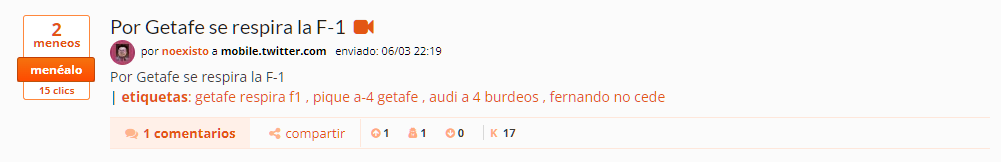

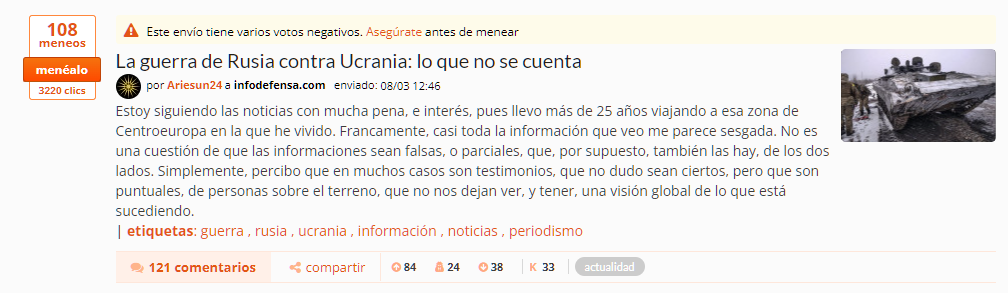

- **"Abuse"**: son las noticias que incumplen las normas de uso de Meneame (ejemplo: spam). Existen muy pocas noticias en esta categoría, omitiremos esta categoría en el entrenamiento de la red neuronal.

- **Auto descartadas**: noticias que el propio usuario que las ha enviado las ha descartado después (normalmente, al darse cuenta que otro usuario la había publicado antes). Hay muy pocas noticias en esta categoría, omitiremos esta categoría en el entrenamiento de la red neuronal.


En este proyecto se propone utilizar **Natural language processing (NLP)**, en concreto una red neuronal de tipo **Transformer**, para la clasificación de futuras noticias.

Como Dataset de entrenamiento se utilizarán las noticias de Meneame.net, las cuales son públicas. Se ha generado un **Dataset** con las noticias, y han sido automáticamente clasificadas en categorías (categorías: relevante, no relevante, polémica, descartada) a partir de las columnas del dataset (votos, votos negativos, estado).

Un esquema resumen:

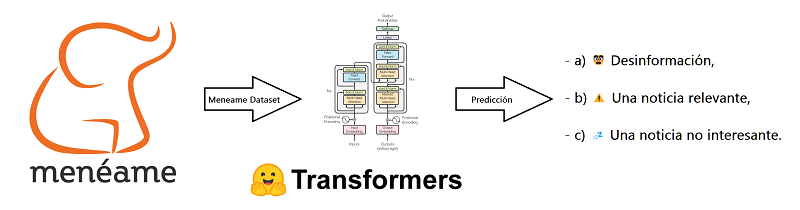


La solución se implementará en Amazon Web Services (**AWS**) utilizando tecnología **Intel**, y participará en el Hackathon For Good https://www.hackathoniberia.com/

Durante la generación del Dataset no es necesario utilizar instancias de cómputo con altas prestaciones. Pero durante el entrenamiento del Modelo sí será necesario utilizar una instancia con GPU y capaz de trabajar con GBs de información, como las instancias Intel que utilizaremos.

Por último, tras entrenar el modelo y probarlo con nuevas noticias (evaluación del modelo), se intentará **publicar utilizando Amazon SageMaker**, para que otras personas puedan inferir resultados vía API.

In [50]:
FOLDER_DATASET = '/home/ec2-user/SageMaker/meneame'

In [51]:
import platform
platform.processor() # Mostrar info del procesador intel

'x86_64'

## 📦 Paso 0. Definir parámetros + Importar las librerías necesarias.

In [52]:
import os
import glob
import os.path

import urllib.request
import json
import time

import pandas as pd
import numpy as np

from datetime import datetime
import random

from sklearn.model_selection import train_test_split

import torch

from enum import Enum

class STATUS(Enum):
  SIN_ESTADO = -1
  RELEVANTE = 0
  DESCARTADA = 1
  POLEMICA = 2
  NO_INTERESANTE = 3

In [53]:
INDEX_TO = 3642387 # - 10000 - 1 # 3642387 # 3642387 es el ID de la última noticia enviada a menéame.net, en el momento de hacer este notebook.
MAX_ITEMS = 10000 # nº de noticias que queremos recopilar en el dataset.
SLEEP_PAUSE = 1 # pausa (en segundos), entre la lectura de 1 noticia y la siguiente noticia.
SPLIT_SIZE = 500 # cada cuántas noticias haremos un guardado intermedio del dataset, para evitar perder datos.

FILENAME_CSV_DATASET = 'full-dataset-meneame.csv'
PATH_DATASET = os.path.join(FOLDER_DATASET, FILENAME_CSV_DATASET)

CLEAN_FILENAME_CSV_DATASET = 'clean-full-dataset-meneame.csv'
CLEAN_PATH_DATASET = os.path.join(FOLDER_DATASET, CLEAN_FILENAME_CSV_DATASET)

# usaremos esta URL para obtener los datos de una noticia de meneame, en formato JSON (ie: poner id=1 para probar)
URL_BASE = 'https://www.meneame.net/backend/info.php?fields=title,content,date,karma,negatives,sent_date,url,clicks,votes,status&id={0}'

FOLDER_OUTPUT = os.path.join(FOLDER_DATASET, 'output') # carpeta local donde se guardará el modelo después de entrenarlo.

S3_BUCKET_NAME = 'sagemaker-meneame' # nombre del bucket a donde se enviará el modelo entrenado.

## 🕷️ Paso 1. Crear el dataset a partir de la web pública de meneame.net, y guardarlo en **Amazon S3**.

Como alternativa, existen datasets públicos de meneame.net ya generados aquí:

- https://zenodo.org/record/2536218#.Yj4f5-eZMQ8
- https://www.kaggle.com/datasets/mrverde/meneamenet-front-page-news

También existe un proyecto open-source para hacer Web Scraping: https://github.com/s-nt-s/meneame.dump

A continuación genero el dataset a partir de los datos públicos de la web. Descarto los datasets anteriores porque o bien se centran solo en las noticias publicadas en la portada de meneame.net (sin recoger las noticias descartadas de meneame), o bien no contienen la columna "status" ("published", "discard", "autodiscard", "queued"...) que para este proyecto es muy importante.

**💸 Nota:** para esta fase de creación del dataset no necesitas ni GPU ni procesador de altas prestaciones. En esta fase puedes reducir costes usando alguna instancia EC2 de la capa gratuita de AWS o una instancia T2/T3 micro: https://aws.amazon.com/ec2/pricing/?loc=ft#Free_tier

In [54]:
# Ejemplo: ver los datos devueltos en JSON por la url, para la noticia id=1:
# Si quieres ver la noticia desde el navegador web, pega en tu navegador la URL https://www.meneame.net/story/1
!curl -H "Accept: application/json" "{URL_BASE.format(1)}"

{"title":"\u00c9sta es la primera noticia meneada","content":"Pues s\u00ed, a las 5 de la ma\u00f1ana he acabado de subir los ficheros y la base de datos para empezar a probar este servidor. Espero que los amigos se den cuenta.","date":"1133928456","karma":"11.00","negatives":"0","sent_date":"1133928253","url":"http:\/\/mnm.uib.es\/gallir\/meneame","clicks":0,"votes":"246","status":""}

In [55]:
# Creamos carpeta para guardar el dataset.
if (os.path.isdir(FOLDER_DATASET)):
  print('FOLDER_DATASET ya existe')
else:
  os.mkdir(FOLDER_DATASET)
  print('FOLDER_DATASET creada :)')

FOLDER_DATASET ya existe


In [56]:
def save_json(all_json, i):
  # print(all_json)

  path_file = FOLDER_DATASET + '/' + str(i) + '-meneame-dataset.json'

  with open(path_file, 'w') as outfile:
    json.dump(all_json, outfile)
    print('Fichero guardado! ' + path_file)

In [8]:
# Bucle encargado de descargar todas las noticias.
# Las almacenará temporalmente cada SPLIT_SIZE noticias, en un fichero JSON en la carpeta FOLDER_DATASET

i_from = INDEX_TO - MAX_ITEMS # 3633001

print('Descargando noticias con ID entre {0} y {1}...'.format(i_from, INDEX_TO))

all_json = []
for i in range(i_from, INDEX_TO):
  if i % SPLIT_SIZE == 0:
    save_json(all_json, i)
    all_json = []

  link = URL_BASE.format(i)

  json_aux = {}
  try:
    with urllib.request.urlopen(link) as url:
      s = url.read()
      json_aux = json.loads(s)
      json_aux['id'] = i

      all_json.append(json_aux)
  except:
    print('error en noticia ID={0}, continuamos...'.format(i))

  time.sleep(SLEEP_PAUSE)
  
save_json(all_json, i)

Descargando noticias con ID entre 3632387 y 3642387...
error en noticia ID=3632388, continuamos...
error en noticia ID=3632419, continuamos...


KeyboardInterrupt: 

In [ ]:
json_aux # mostrar el último bloque JSON como ejemplo de grupo de noticias recopiladas

In [57]:
# ver el listado de ficheros JSON intermedios generados.
list_files = glob.glob(os.path.join(FOLDER_DATASET,'*.json'))
list_files

['/home/ec2-user/SageMaker/meneame/3628000-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3641500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3639500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3631500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3628500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3625000-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3625500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3629500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3639000-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3627000-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3624000-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3633500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3631000-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3634500-meneame-dataset.json',
 '/home/ec2-user/SageMaker/meneame/3636500-meneame-dataset.json',
 '/home/ec

In [58]:
# concatenar todos esos ficheros intermedios, en un único Dataframe
df = None
for one_json in list_files:
  df_aux = pd.read_json(one_json)
  print(one_json + ' | ' + str(len(df_aux)))
  if df is None:
    df = df_aux
  else:
    df = pd.concat([df, df_aux], ignore_index=True)

/home/ec2-user/SageMaker/meneame/3628000-meneame-dataset.json | 436
/home/ec2-user/SageMaker/meneame/3641500-meneame-dataset.json | 395
/home/ec2-user/SageMaker/meneame/3639500-meneame-dataset.json | 413
/home/ec2-user/SageMaker/meneame/3631500-meneame-dataset.json | 425
/home/ec2-user/SageMaker/meneame/3628500-meneame-dataset.json | 417
/home/ec2-user/SageMaker/meneame/3625000-meneame-dataset.json | 430
/home/ec2-user/SageMaker/meneame/3625500-meneame-dataset.json | 426
/home/ec2-user/SageMaker/meneame/3629500-meneame-dataset.json | 421
/home/ec2-user/SageMaker/meneame/3639000-meneame-dataset.json | 423
/home/ec2-user/SageMaker/meneame/3627000-meneame-dataset.json | 433
/home/ec2-user/SageMaker/meneame/3624000-meneame-dataset.json | 436
/home/ec2-user/SageMaker/meneame/3633500-meneame-dataset.json | 403
/home/ec2-user/SageMaker/meneame/3631000-meneame-dataset.json | 412
/home/ec2-user/SageMaker/meneame/3634500-meneame-dataset.json | 401
/home/ec2-user/SageMaker/meneame/3636500-meneame

In [59]:
len(df) # nº total noticias recopiladas (será inferior a MAX_ITEMS porque algunos ID de noticia han dado error).

16510

In [60]:
df # mostrar el Dataframe

,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id
0,El vibrador a lo largo de la historia,El vibrador no siempre fue motivo de diversión...,2022-02-22 16:32:00,8,1,1645547520,https://culturainquieta.com/es/lifestyle/item/...,0,8,queued,3627500
1,Esta profesora de Lengua puntúa con memes sus ...,&quot;Nuestra profesora de lengua poniéndonos ...,2022-02-22 16:32:56,66,1,1645547576,https://www.genbeta.com/redes-sociales-y-comun...,0,8,queued,3627501
2,Bruselas urge a España a reforzar sus intercon...,Las reservas de almacenamiento de gas se encue...,2022-02-22 16:36:50,9,0,1645547810,https://www.elboletin.com/bruselas-urge-a-espa...,0,13,queued,3627502
3,La CE reconoce en bloque a Croacia y Eslovenia,&quot;La Comunidad y sus Estados miembros han ...,2022-02-22 16:37:17,26,0,1645547837,https://elpais.com/diario/1992/01/16/internaci...,0,2,queued,3627503
4,Un Airbus A400M lanza por primera vez un dron ...,El Airbus A400M ha completado el lanzamiento e...,2022-02-22 16:37:32,4,0,1645547852,http://galaxiamilitar.es/un-airbus-a400m-lanza...,0,5,queued,3627504
...,...,...,...,...,...,...,...,...,...,...,...
16505,El Gran Índice de la Italianidad: los países y...,Una nueva encuesta internacional muestra que e...,2022-02-12 17:05:42,131,1,1644666436,https://magnet.xataka.com/why-so-serious/gran-...,0,19,published,3622995
16506,Pablo Casado amplía el bulo sobre Garzón: &quo...,"El líder del PP, Pablo Casado, insiste en seña...",2022-02-12 11:48:01,16,8,1644666481,https://www.elplural.com/elplural-tv/politica-...,0,36,queued,3622996
16507,Casado: &quot;Castilla y León es la cuna de la...,Casado: &quot;Castilla y León es la cuna de la...,2022-02-12 11:59:49,114,0,1644667189,https://twitter.com/ElHuffPost/status/14922081...,0,19,queued,3622997
16508,"Carnavales Cádiz 2022: Barras en las calles, h...",La fiesta oficiosa se celebrará desde el 26 de...,2022-02-12 12:00:56,30,0,1644667256,https://www.lavozdigital.es/cadiz/lvdi-barras-...,0,3,queued,3622998


In [61]:
# comprobación de que no hay noticias repes por algún error en la generación del dataset.
nunique = df['id'].nunique()
n_rows = len(df)

if nunique == n_rows:
  print('OK, no hay IDs repetidos.')
else:
  print('Error, hay filas repetidas en el dataset. Limpia los datos por favor.')

OK, no hay IDs repetidos.


In [62]:
# Guardar todo el dataset en un único fichero .CSV.
df.to_csv(PATH_DATASET)
print('CSV guardado :)')

CSV guardado :)


## 📊 Paso 2. Abrir dataset y Análisis exploratorio de datos (EDA).

In [63]:
df = pd.read_csv(PATH_DATASET, sep=",")
df

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id
0,0,El vibrador a lo largo de la historia,El vibrador no siempre fue motivo de diversión...,2022-02-22 16:32:00,8,1,1645547520,https://culturainquieta.com/es/lifestyle/item/...,0,8,queued,3627500
1,1,Esta profesora de Lengua puntúa con memes sus ...,&quot;Nuestra profesora de lengua poniéndonos ...,2022-02-22 16:32:56,66,1,1645547576,https://www.genbeta.com/redes-sociales-y-comun...,0,8,queued,3627501
2,2,Bruselas urge a España a reforzar sus intercon...,Las reservas de almacenamiento de gas se encue...,2022-02-22 16:36:50,9,0,1645547810,https://www.elboletin.com/bruselas-urge-a-espa...,0,13,queued,3627502
3,3,La CE reconoce en bloque a Croacia y Eslovenia,&quot;La Comunidad y sus Estados miembros han ...,2022-02-22 16:37:17,26,0,1645547837,https://elpais.com/diario/1992/01/16/internaci...,0,2,queued,3627503
4,4,Un Airbus A400M lanza por primera vez un dron ...,El Airbus A400M ha completado el lanzamiento e...,2022-02-22 16:37:32,4,0,1645547852,http://galaxiamilitar.es/un-airbus-a400m-lanza...,0,5,queued,3627504
...,...,...,...,...,...,...,...,...,...,...,...,...
16505,16505,El Gran Índice de la Italianidad: los países y...,Una nueva encuesta internacional muestra que e...,2022-02-12 17:05:42,131,1,1644666436,https://magnet.xataka.com/why-so-serious/gran-...,0,19,published,3622995
16506,16506,Pablo Casado amplía el bulo sobre Garzón: &quo...,"El líder del PP, Pablo Casado, insiste en seña...",2022-02-12 11:48:01,16,8,1644666481,https://www.elplural.com/elplural-tv/politica-...,0,36,queued,3622996
16507,16507,Casado: &quot;Castilla y León es la cuna de la...,Casado: &quot;Castilla y León es la cuna de la...,2022-02-12 11:59:49,114,0,1644667189,https://twitter.com/ElHuffPost/status/14922081...,0,19,queued,3622997
16508,16508,"Carnavales Cádiz 2022: Barras en las calles, h...",La fiesta oficiosa se celebrará desde el 26 de...,2022-02-12 12:00:56,30,0,1644667256,https://www.lavozdigital.es/cadiz/lvdi-barras-...,0,3,queued,3622998


In [64]:
df.describe()

,Unnamed: 0,karma,negatives,sent_date,clicks,votes,id
count,16510.000000,16510.000000,16510.000000,1.651000e+04,16510.0,16510.000000,1.651000e+04
mean,8254.500000,308.982738,3.265475,1.646318e+09,0.0,30.227135,3.632218e+06
std,4766.170808,853.177662,6.436913,9.740325e+05,0.0,58.634038,5.736943e+03
min,0.000000,-369.000000,0.000000,1.644542e+09,0.0,0.000000,3.622386e+06
25%,4127.250000,6.000000,0.000000,1.645521e+09,0.0,3.000000,3.627243e+06
50%,8254.500000,44.000000,1.000000,1.646316e+09,0.0,10.000000,3.632138e+06
75%,12381.750000,94.000000,4.000000,1.647164e+09,0.0,23.000000,3.637186e+06
max,16509.000000,8627.000000,154.000000,1.648033e+09,0.0,606.000000,3.642386e+06


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16510 entries, 0 to 16509
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16510 non-null  int64 
 1   title       14704 non-null  object
 2   content     14698 non-null  object
 3   date        16510 non-null  object
 4   karma       16510 non-null  int64 
 5   negatives   16510 non-null  int64 
 6   sent_date   16510 non-null  int64 
 7   url         14093 non-null  object
 8   clicks      16510 non-null  int64 
 9   votes       16510 non-null  int64 
 10  status      16461 non-null  object
 11  id          16510 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 1.5+ MB


### Comprobar cuántos items hay de cada "status", para decidir si omitir algunos de los estados (por ejemplo, estado "auto discard" o "abuse").

In [66]:
df.groupby("status").count()

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,id
status,,,,,,,,,,,
abuse,243,243,242,243,243,243,243,139,243,243,243
autodiscard,886,886,886,886,886,886,886,873,886,886,886
discard,2634,830,827,2634,2634,2634,2634,793,2634,2634,2634
private,54,54,54,54,54,54,54,0,54,54,54
published,2551,2551,2551,2551,2551,2551,2551,2341,2551,2551,2551
queued,10093,10092,10089,10093,10093,10093,10093,9898,10093,10093,10093


In [67]:
df['one'] = 1

In [11]:
%pip install plotly

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [68]:
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "iframe"

fig = px.pie(df, values='one', names='status')
fig.show()


In [69]:
df[df['status'].isna()] # errores en BBDD de meneame? estas noticias sin estado están repetidas; aparecen en otras filas con estado. Decisión: no usar estas filas en entrenamiento

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one
48,48,Transhumanos | El siguiente paso de la evoluci...,"El transhumanismo, la integración del cuerpo h...",2022-02-22 18:36:44,0,0,1645555004,https://www.laverdad.es/xlsemanal/ciencia/tran...,0,0,NaN,3627552,1
1179,1179,"CGT, junto a la mesa de unidad sindical, solic...",Desde que comenzó el proceso de apertura de nu...,2022-03-17 10:42:40,0,0,1647513761,https://twitter.com/CGTCorreos_/status/1504095...,0,0,NaN,3639420,1
1180,1180,"CGT, junto a la mesa de unidad sindical, solic...",Desde que comenzó el proceso de apertura de nu...,2022-03-17 10:42:41,0,0,1647513762,https://twitter.com/CGTCorreos_/status/1504095...,0,0,NaN,3639421,1
1685,1685,Esto podemos esperar tras la conquista de Ucra...,Supongamos por un momento que Vladímir Putin l...,2022-02-23 17:31:33,0,0,1645637498,https://www.washingtonpost.com/es/post-opinion...,0,0,NaN,3628021,1
1686,1686,Esto podemos esperar tras la conquista de Ucra...,Supongamos por un momento que Vladímir Putin l...,2022-02-23 17:31:38,0,0,1645637503,https://www.washingtonpost.com/es/post-opinion...,0,0,NaN,3628022,1
1729,1729,Canal Sur sanciona duramente a un periodista d...,"El periodista, con 33 años de servicio en Cana...",2022-02-23 19:50:46,0,0,1645645846,https://www.elindependientedegranada.es/comuni...,0,0,NaN,3628072,1
1973,1973,Memorándum de Budapest1994.Garantías de seguri...,El Memorándum de Budapest sobre Garantías de S...,2022-02-24 12:08:24,26,1,1645704504,https://conucrania.com/2014/09/09/memorandum-d...,0,5,NaN,3628362,1
2005,2005,Registran por primera vez lo que ocurre en el ...,Se me ocurren un puñado de películas y libros ...,2022-02-24 13:13:35,0,0,1645708416,https://es.gizmodo.com/un-estudio-registra-por...,0,0,NaN,3628397,1
2790,2790,Carromero dimite tras su participación en el e...,"El coordinador general de la Alcaldía, amigo p...",2022-02-17 17:04:05,0,0,1645117446,https://www.elconfidencial.com/espana/2022-02-...,0,0,NaN,3625327,1
3823,3823,Aparece finalmente la denuncia contra Margarit...,La Audiencia Nacional había admitido a trámite...,2022-02-20 16:43:28,0,0,1645375409,https://www.acodap.com/el-milagro-de-la-denunc...,0,0,NaN,3626539,1


In [70]:
df = df[df['title'].isna() == False] # eliminar filas con title=Null
df

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one
0,0,El vibrador a lo largo de la historia,El vibrador no siempre fue motivo de diversión...,2022-02-22 16:32:00,8,1,1645547520,https://culturainquieta.com/es/lifestyle/item/...,0,8,queued,3627500,1
1,1,Esta profesora de Lengua puntúa con memes sus ...,&quot;Nuestra profesora de lengua poniéndonos ...,2022-02-22 16:32:56,66,1,1645547576,https://www.genbeta.com/redes-sociales-y-comun...,0,8,queued,3627501,1
2,2,Bruselas urge a España a reforzar sus intercon...,Las reservas de almacenamiento de gas se encue...,2022-02-22 16:36:50,9,0,1645547810,https://www.elboletin.com/bruselas-urge-a-espa...,0,13,queued,3627502,1
3,3,La CE reconoce en bloque a Croacia y Eslovenia,&quot;La Comunidad y sus Estados miembros han ...,2022-02-22 16:37:17,26,0,1645547837,https://elpais.com/diario/1992/01/16/internaci...,0,2,queued,3627503,1
4,4,Un Airbus A400M lanza por primera vez un dron ...,El Airbus A400M ha completado el lanzamiento e...,2022-02-22 16:37:32,4,0,1645547852,http://galaxiamilitar.es/un-airbus-a400m-lanza...,0,5,queued,3627504,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16505,16505,El Gran Índice de la Italianidad: los países y...,Una nueva encuesta internacional muestra que e...,2022-02-12 17:05:42,131,1,1644666436,https://magnet.xataka.com/why-so-serious/gran-...,0,19,published,3622995,1
16506,16506,Pablo Casado amplía el bulo sobre Garzón: &quo...,"El líder del PP, Pablo Casado, insiste en seña...",2022-02-12 11:48:01,16,8,1644666481,https://www.elplural.com/elplural-tv/politica-...,0,36,queued,3622996,1
16507,16507,Casado: &quot;Castilla y León es la cuna de la...,Casado: &quot;Castilla y León es la cuna de la...,2022-02-12 11:59:49,114,0,1644667189,https://twitter.com/ElHuffPost/status/14922081...,0,19,queued,3622997,1
16508,16508,"Carnavales Cádiz 2022: Barras en las calles, h...",La fiesta oficiosa se celebrará desde el 26 de...,2022-02-12 12:00:56,30,0,1644667256,https://www.lavozdigital.es/cadiz/lvdi-barras-...,0,3,queued,3622998,1


### Generar la columna "final_status", que será la columna target para el modelo.

In [71]:
def set_final_status(row):
  ret = STATUS.SIN_ESTADO.value

  if row['status'] == 'published':
    # Si status es "published"                      --> final_status = relevante.
    ret = STATUS.RELEVANTE.value
  elif row['status'] == 'discard':
    # Si status es "discard"                        --> final_status = descartada.
    ret = STATUS.DESCARTADA.value
  elif row['status'] == 'queued' and row['negatives'] >= 15:
    # Si status es "queued" pero nº negativos >= 15 --> final_status = polemica.
    ret = STATUS.POLEMICA.value
  elif row['status'] == 'queued' and row['negatives'] < 15:
    # Si status es "queued" y nº negativos < 15     --> final_status = no interesante.
    ret = STATUS.NO_INTERESANTE.value

  return ret

In [72]:
df['final_status'] = df.apply(lambda x : set_final_status(x), axis=1)

/tmp/ipykernel_1484/3285956169.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
df[df['final_status'] == STATUS.POLEMICA.value]

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one,final_status
64,64,Ucrania: rigor frente a propaganda,"Pablo Iglesias, Sara Serrano y Manu Levin anal...",2022-02-22 19:38:05,91,17,1645558685,https://www.youtube.com/watch?v=ax1-emuO6Vg,0,68,queued,3627571,1,2
86,86,Desmontando liberales edición definitiva: UTBH...,Hoy os traigo la edición definitiva de &quot;D...,2022-02-22 20:36:05,13,32,1645562165,https://www.youtube.com/watch?v=TxES1II7kvQ,0,30,queued,3627593,1,2
102,102,Dakar: Cristina Gutiérrez consigue subirse al ...,La española es la tercera mujer que lo logra e...,2022-02-22 21:37:54,0,17,1645565874,https://www.caranddriver.com/es/motorsport/a38...,0,11,queued,3627613,1,2
147,147,"Todos los frentes de la nueva Guerra Fría, exp...",El viejo Telón de Acero vuelve a levantarse en...,2022-02-23 02:07:28,-18,19,1645582048,https://www.elmundo.es/internacional/2022/02/2...,0,15,queued,3627663,1,2
159,159,La periodista Victoria Maso hace historia al p...,Con el hashtag &quot;Contra la tiranía del tac...,2022-02-23 05:13:01,19,61,1645593181,https://cadenaser.com/2022/02/22/presentar-un-...,0,121,queued,3627676,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15989,15989,"Rusia ha ganado la guerra, lo que queda son la...","Larry C. Johnson, un antiguo oficial de la CIA...",2022-03-22 21:19:00,31,16,1647983940,https://mpr21.info/rusia-ha-ganado-la-guerra-l...,0,26,queued,3642236,1,2
16006,16006,Bashar al Assad comenta sobre cómo se entiende...,"En su visita a Emiratos Árabes Unidos, el pres...",2022-03-22 22:00:55,0,22,1647986455,https://odysee.com/@ActualidadRT:9/Bashar_al_A...,0,36,queued,3642257,1,2
16042,16042,La conversación de una hostelera con una aspir...,Se trata de una captura de pantalla en la que ...,2022-03-23 05:06:12,-54,63,1648011972,https://www.huffingtonpost.es/amp/entry/la-con...,0,153,queued,3642302,1,2
16247,16247,Pablo Iglesias: &quot;Me han atribuido ser mu...,Pablo Iglesias se confesó sobre su paso por la...,2022-02-11 15:09:23,37,15,1644592163,https://elcierredigital.com/ventana-indiscreta...,0,12,queued,3622684,1,2


In [74]:
df[df['final_status'] == STATUS.DESCARTADA.value]

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one,final_status
5,5,&quot;En España los que más violan y pegan a s...,Morad fue el primer entrevistado de la nueva t...,2022-02-22 16:38:22,-47,20,1645547902,https://spanishrevolution.net/morad-contra-el-...,0,11,discard,3627505,1,1
18,18,Más suicidios entre ateos y agnósticos que ent...,Un estudio realizado por las universidades de ...,2022-02-22 17:08:54,-44,9,1645549734,https://protestantedigital.com/internacional/2...,0,1,discard,3627519,1,1
63,63,"Esta historia lo tiene todo: Lana Rhoades, de ...",La historia se puede resumir en dos palabras: ...,2022-02-22 19:38:10,-35,8,1645558690,https://hipertextual.com/2022/02/lana-rhoades-...,0,2,discard,3627570,1,1
65,65,"Cómo se hizo «El Talismán», la novela coescrit...",Stephen King y Peter Straub cuentan cómo fue e...,2022-02-22 19:43:30,-50,7,1645559010,https://lazonamuerta.substack.com/p/como-se-hi...,0,2,discard,3627572,1,1
73,73,El PP entregó el Tribunal de Cuentas al PSOE a...,"Teodoro García Egea, pactó con el ministro de ...",2022-02-22 20:13:04,-34,12,1645560784,https://www.libertaddigital.com/espana/2022-02...,0,7,discard,3627580,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16367,16367,La Policía Nacional elimina el examen de Ortog...,Las próximas pruebas de acceso a la Policía Na...,2022-02-11 20:37:21,-39,8,1644611841,https://www.lavanguardia.com/politica/20220209...,0,3,discard,3622834,1,1
16404,16404,Hombre llama al 016 para su hermano,Hombre llama al 016 para ver si le atienden po...,2022-02-11 23:10:30,-39,12,1644621030,https://www.youtube.com/watch?v=otKTx6By7kE,0,5,discard,3622874,1,1
16451,16451,Esto es lo que ocurre cuando abres 6.000 pesta...,El Mac Pro ha sido el &quot;ratón de laborator...,2022-02-12 09:00:03,-46,8,1644656403,https://www.applesfera.com/curiosidades/esto-q...,0,1,discard,3622936,1,1
16492,16492,Estados Unidos cierra su embajada en Ucrania a...,Estados Unidos ha decidido cerrar su embajada ...,2022-02-12 11:10:50,-27,7,1644664250,https://www.elmundo.es/internacional/2022/02/1...,0,4,discard,3622981,1,1


In [75]:
df[df['status'] == 'abuse'] # las noticias de status=abuse no las usaremos; son pocas y mayoritaritariamente son noticias de spam.

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one,final_status
31,31,El plasta sin vida mendigando visitas,"Ataúlfo, Sigerico, Walia, Teodorico I, Turismu...",2022-02-22 17:43:53,-16,2,1645551833,https://www.ine.es,0,1,abuse,3627533,1,-1
132,132,El plasta sin vida mendigando visitas 2,Soy un pesado sin vida propia y no tengo nada ...,2022-02-22 23:10:20,-57,9,1645571420,https://youtu.be/bj79hyNsDgQ,0,3,abuse,3627643,1,-1
254,254,Pentagon Digital Agency,<p>pentagon Digital Agency is a 24-Year-Old We...,2022-02-23 10:16:21,6,0,1645611381,NaN,0,1,abuse,3627790,1,-1
349,349,El plasta sin vida mendigando visitas 3,Soy un pesado sin vida propia y no tengo nada ...,2022-02-23 13:09:31,-133,24,1645621771,https://www.facebook.com/Cholloplus/,0,10,abuse,3627898,1,-1
357,357,El plasta sin vida mendigando visitas 4,Soy un pesado sin vida propia y no tengo nada ...,2022-02-23 13:25:19,-20,4,1645622719,https://www.facebook.com/Cholloplus/,0,2,abuse,3627909,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16107,16107,Karner H - Night City (CyberPunk 2077 Vr 360°),<p></p>,2022-02-11 09:46:21,6,0,1644572781,NaN,0,1,abuse,3622513,1,-1
16154,16154,ROHS &amp; Regulatory Compliance,<p>We use technologically-advanced instruments...,2022-02-11 11:23:30,-36,5,1644578610,NaN,0,1,abuse,3622568,1,-1
16214,16214,Argentina ganará el Mundial de Qatar según la ...,<p>pod&eacute;is comprobar que todos los c&aac...,2022-02-11 13:24:43,-5,2,1644585883,NaN,0,1,abuse,3622641,1,-1
16419,16419,"Meneame censura y manipula, os vais a joder",<p></p>,2022-02-12 04:41:28,9,1,1644640888,NaN,0,2,abuse,3622890,1,-1


In [76]:
df_clean = df[df['final_status'] != -1]
df_clean

,Unnamed: 0,title,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one,final_status
0,0,El vibrador a lo largo de la historia,El vibrador no siempre fue motivo de diversión...,2022-02-22 16:32:00,8,1,1645547520,https://culturainquieta.com/es/lifestyle/item/...,0,8,queued,3627500,1,3
1,1,Esta profesora de Lengua puntúa con memes sus ...,&quot;Nuestra profesora de lengua poniéndonos ...,2022-02-22 16:32:56,66,1,1645547576,https://www.genbeta.com/redes-sociales-y-comun...,0,8,queued,3627501,1,3
2,2,Bruselas urge a España a reforzar sus intercon...,Las reservas de almacenamiento de gas se encue...,2022-02-22 16:36:50,9,0,1645547810,https://www.elboletin.com/bruselas-urge-a-espa...,0,13,queued,3627502,1,3
3,3,La CE reconoce en bloque a Croacia y Eslovenia,&quot;La Comunidad y sus Estados miembros han ...,2022-02-22 16:37:17,26,0,1645547837,https://elpais.com/diario/1992/01/16/internaci...,0,2,queued,3627503,1,3
4,4,Un Airbus A400M lanza por primera vez un dron ...,El Airbus A400M ha completado el lanzamiento e...,2022-02-22 16:37:32,4,0,1645547852,http://galaxiamilitar.es/un-airbus-a400m-lanza...,0,5,queued,3627504,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16505,16505,El Gran Índice de la Italianidad: los países y...,Una nueva encuesta internacional muestra que e...,2022-02-12 17:05:42,131,1,1644666436,https://magnet.xataka.com/why-so-serious/gran-...,0,19,published,3622995,1,0
16506,16506,Pablo Casado amplía el bulo sobre Garzón: &quo...,"El líder del PP, Pablo Casado, insiste en seña...",2022-02-12 11:48:01,16,8,1644666481,https://www.elplural.com/elplural-tv/politica-...,0,36,queued,3622996,1,3
16507,16507,Casado: &quot;Castilla y León es la cuna de la...,Casado: &quot;Castilla y León es la cuna de la...,2022-02-12 11:59:49,114,0,1644667189,https://twitter.com/ElHuffPost/status/14922081...,0,19,queued,3622997,1,3
16508,16508,"Carnavales Cádiz 2022: Barras en las calles, h...",La fiesta oficiosa se celebrará desde el 26 de...,2022-02-12 12:00:56,30,0,1644667256,https://www.lavozdigital.es/cadiz/lvdi-barras-...,0,3,queued,3622998,1,3


In [77]:
fig = px.pie(df_clean, values='one', names='final_status')
fig.show()

'''
  RELEVANTE = 0       (19%)
  DESCARTADA = 1      (6%)
  POLEMICA = 2        (2.5%)
  NO_INTERESANTE = 3  (72%)
'''

'\n  RELEVANTE = 0       (19%)\n  DESCARTADA = 1      (6%)\n  POLEMICA = 2        (2.5%)\n  NO_INTERESANTE = 3  (72%)\n'

status
abuse          AxesSubplot(0.125,0.125;0.775x0.755)
autodiscard    AxesSubplot(0.125,0.125;0.775x0.755)
discard        AxesSubplot(0.125,0.125;0.775x0.755)
private        AxesSubplot(0.125,0.125;0.775x0.755)
published      AxesSubplot(0.125,0.125;0.775x0.755)
queued         AxesSubplot(0.125,0.125;0.775x0.755)
Name: votes, dtype: object

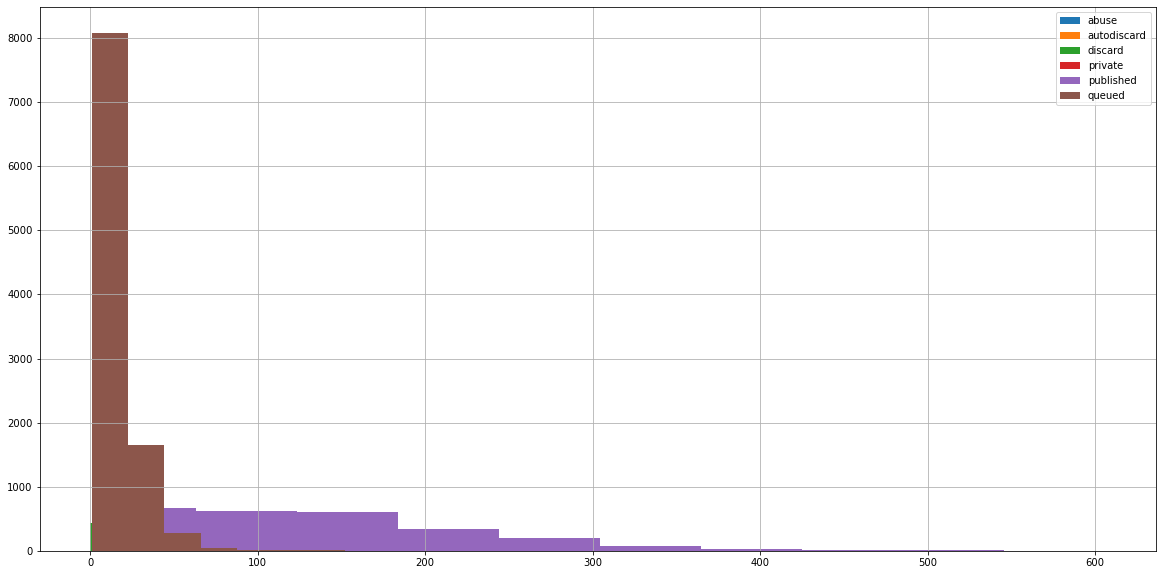

In [78]:
import matplotlib.pyplot as plt

df.groupby("status")['votes'].hist(figsize=(20, 10), legend=True)

status
discard      AxesSubplot(0.125,0.125;0.775x0.755)
published    AxesSubplot(0.125,0.125;0.775x0.755)
queued       AxesSubplot(0.125,0.125;0.775x0.755)
Name: votes, dtype: object

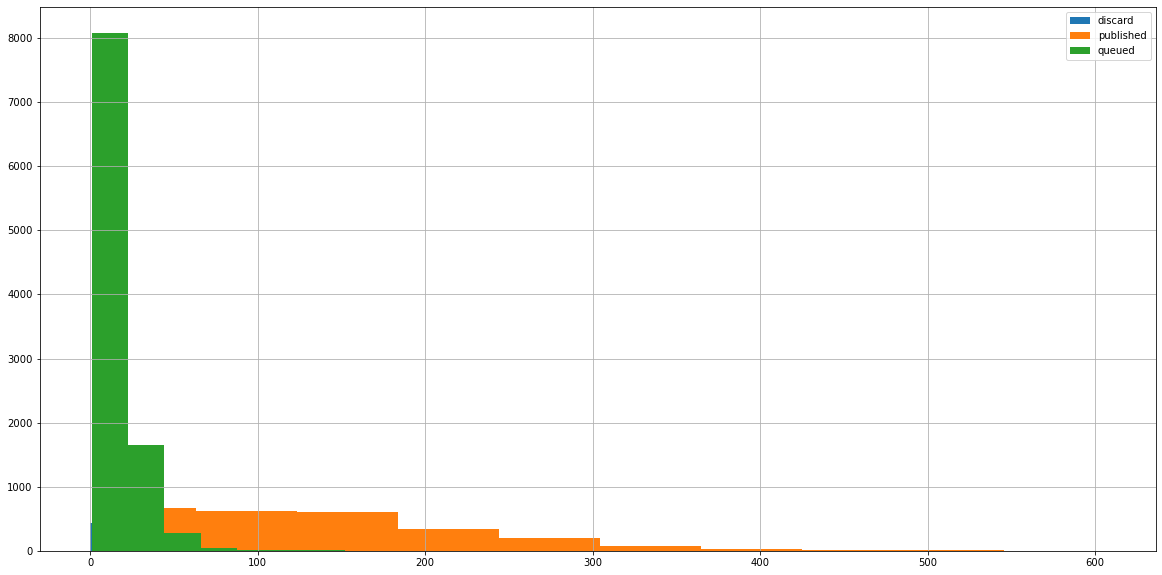

In [79]:
df_clean.groupby("status")['votes'].hist(figsize=(20, 10), legend=True)

status
abuse          AxesSubplot(0.125,0.125;0.775x0.755)
autodiscard    AxesSubplot(0.125,0.125;0.775x0.755)
discard        AxesSubplot(0.125,0.125;0.775x0.755)
private        AxesSubplot(0.125,0.125;0.775x0.755)
published      AxesSubplot(0.125,0.125;0.775x0.755)
queued         AxesSubplot(0.125,0.125;0.775x0.755)
Name: negatives, dtype: object

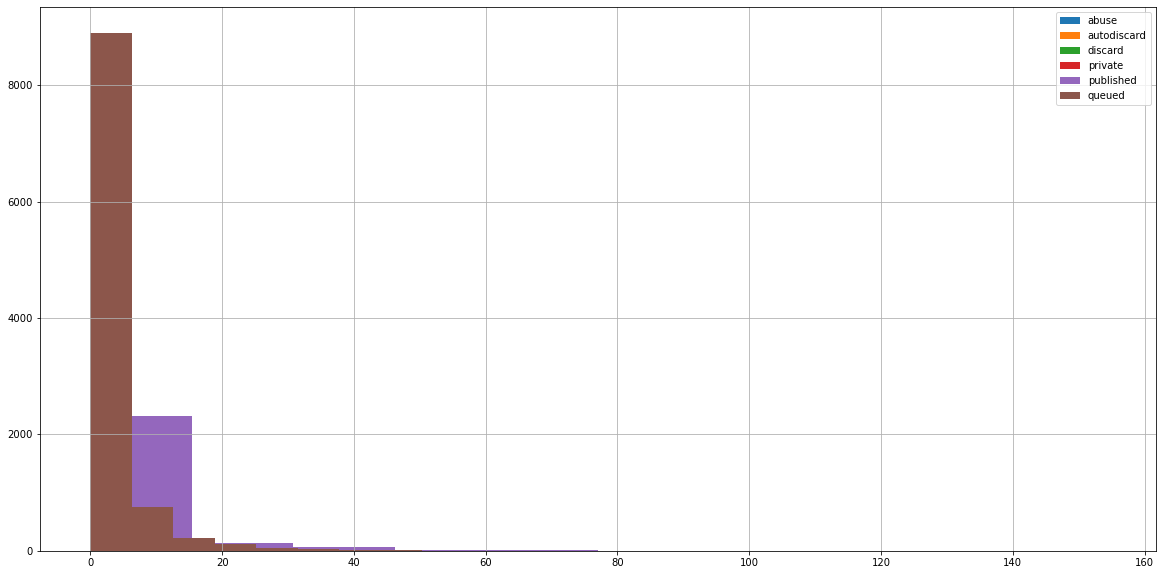

In [80]:
df.groupby("status")['negatives'].hist(figsize=(20, 10), legend=True)

status
discard      AxesSubplot(0.125,0.125;0.775x0.755)
published    AxesSubplot(0.125,0.125;0.775x0.755)
queued       AxesSubplot(0.125,0.125;0.775x0.755)
Name: negatives, dtype: object

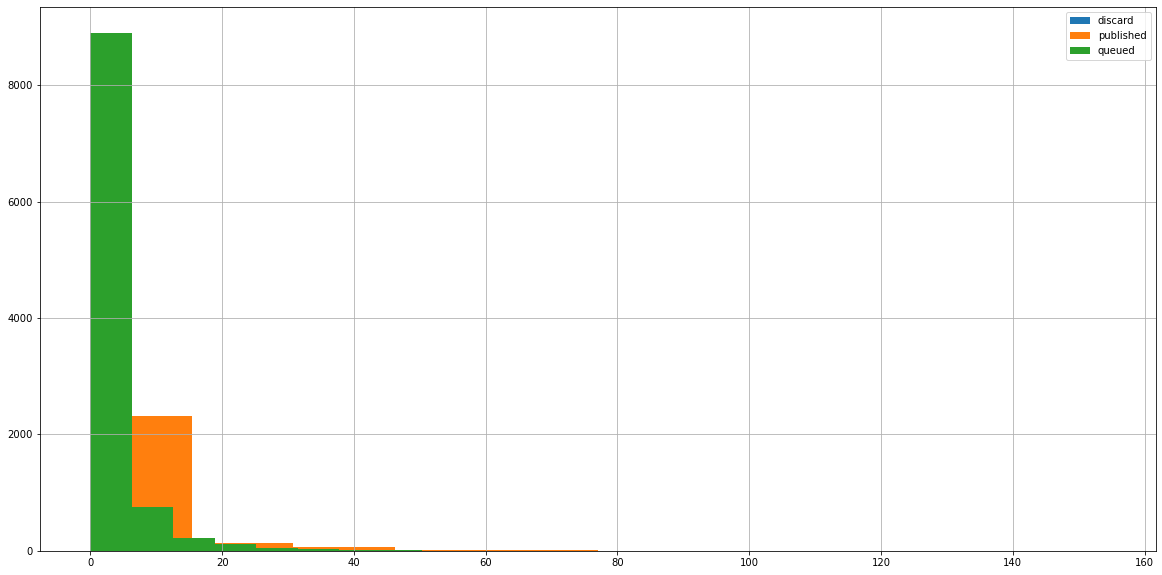

In [81]:
df_clean.groupby("status")['negatives'].hist(figsize=(20, 10), legend=True)

In [82]:
# Guardar todo el dataset en un único fichero .CSV.
df_clean.to_csv(CLEAN_PATH_DATASET)
print('CSV CLEAN guardado :)')

CSV CLEAN guardado :)


#### 🗃️➡️☁️ Guardar también en S3 el dataset:

In [38]:
import boto3, os

print('Subiendo dataset a S3...')

boto3.Session().resource('s3').Bucket(S3_BUCKET_NAME).Object(FILENAME_CSV_DATASET).upload_file(PATH_DATASET)

print('Subido a S3 el dataset :)')

Subiendo dataset a S3...
Subido a S3 el dataset :)


## ⚙️ Paso 3. Configurar el modelo NLP y los hiperparámetros para el entrenamiento.

**⚡ Nota:** A partir de este paso sí que necesitaremos una **instancia con altas prestaciones**. ¿Por qué? Porque utilizaremos Transformers, que son un tipo de Arquitectura de redes neuronales utilizada para Procesamiento de Lenguaje Natural (NLP), y que requieren mucha memoria GPU y procesan muchos GBs de información.

In [83]:
if torch.cuda.is_available() == False:
  print('Error, selecciona una instancia con GPU.')
else:
  print('OK, instancia con GPU :)')

OK, instancia con GPU :)


In [84]:
df_clean = pd.read_csv(CLEAN_PATH_DATASET, sep=",")

# Renombrado de las columnas para tener "text" (input) y "labels" (predicción)
df_clean.rename(columns = {'title':'text', 'final_status':'labels'}, inplace = True)

df_clean

,Unnamed: 0,Unnamed: 0.1,text,content,date,karma,negatives,sent_date,url,clicks,votes,status,id,one,labels
0,0,0,El vibrador a lo largo de la historia,El vibrador no siempre fue motivo de diversión...,2022-02-22 16:32:00,8,1,1645547520,https://culturainquieta.com/es/lifestyle/item/...,0,8,queued,3627500,1,3
1,1,1,Esta profesora de Lengua puntúa con memes sus ...,&quot;Nuestra profesora de lengua poniéndonos ...,2022-02-22 16:32:56,66,1,1645547576,https://www.genbeta.com/redes-sociales-y-comun...,0,8,queued,3627501,1,3
2,2,2,Bruselas urge a España a reforzar sus intercon...,Las reservas de almacenamiento de gas se encue...,2022-02-22 16:36:50,9,0,1645547810,https://www.elboletin.com/bruselas-urge-a-espa...,0,13,queued,3627502,1,3
3,3,3,La CE reconoce en bloque a Croacia y Eslovenia,&quot;La Comunidad y sus Estados miembros han ...,2022-02-22 16:37:17,26,0,1645547837,https://elpais.com/diario/1992/01/16/internaci...,0,2,queued,3627503,1,3
4,4,4,Un Airbus A400M lanza por primera vez un dron ...,El Airbus A400M ha completado el lanzamiento e...,2022-02-22 16:37:32,4,0,1645547852,http://galaxiamilitar.es/un-airbus-a400m-lanza...,0,5,queued,3627504,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13468,16505,16505,El Gran Índice de la Italianidad: los países y...,Una nueva encuesta internacional muestra que e...,2022-02-12 17:05:42,131,1,1644666436,https://magnet.xataka.com/why-so-serious/gran-...,0,19,published,3622995,1,0
13469,16506,16506,Pablo Casado amplía el bulo sobre Garzón: &quo...,"El líder del PP, Pablo Casado, insiste en seña...",2022-02-12 11:48:01,16,8,1644666481,https://www.elplural.com/elplural-tv/politica-...,0,36,queued,3622996,1,3
13470,16507,16507,Casado: &quot;Castilla y León es la cuna de la...,Casado: &quot;Castilla y León es la cuna de la...,2022-02-12 11:59:49,114,0,1644667189,https://twitter.com/ElHuffPost/status/14922081...,0,19,queued,3622997,1,3
13471,16508,16508,"Carnavales Cádiz 2022: Barras en las calles, h...",La fiesta oficiosa se celebrará desde el 26 de...,2022-02-12 12:00:56,30,0,1644667256,https://www.lavozdigital.es/cadiz/lvdi-barras-...,0,3,queued,3622998,1,3


In [85]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13473 entries, 0 to 13472
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    13473 non-null  int64 
 1   Unnamed: 0.1  13473 non-null  int64 
 2   text          13473 non-null  object
 3   content       13465 non-null  object
 4   date          13473 non-null  object
 5   karma         13473 non-null  int64 
 6   negatives     13473 non-null  int64 
 7   sent_date     13473 non-null  int64 
 8   url           13030 non-null  object
 9   clicks        13473 non-null  int64 
 10  votes         13473 non-null  int64 
 11  status        13473 non-null  object
 12  id            13473 non-null  int64 
 13  one           13473 non-null  int64 
 14  labels        13473 non-null  int64 
dtypes: int64(10), object(5)
memory usage: 1.5+ MB


In [42]:
%pip install -q simpletransformers==0.51.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import AutoTokenizer, AutoModel

In [6]:
transformers_version='4.12.3'
pytorch_version='1.9.1'
py_version='py38'

In [7]:
GLOBAL_SEED = 33

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print('SEED: ' + str(seed))

In [8]:
class experiment: 
  def __init__(self, SUBMISSION_NUM, FOLDER, FORCE_LOWERCASE, MODEL_TYPE, MODEL_NAME, AUTO_TOKENIZER_NAME, P_TEST_SIZE, P_TRAIN_SIZE, LOAD_TRAIN_AND_TEST_SETS, FILENAME_INPUT_SUFIX, NUM_TRAIN_EPOCHS, IS_FP16_ENABLED, MAX_SEQ_LENGTH, EVAL_BATCH_SIZE, TRAIN_BATCH_SIZE, CONFIG_GRADIENT_ACCUMULATION_STEPS, LEARNING_RATE, CONFIG_NO_SAVE_MODEL, WARMUP_STEPS=0): 
    self.FORCE_LOWERCASE = FORCE_LOWERCASE

    self.MODEL_TYPE = MODEL_TYPE # Ejemplos: 'bert'
    self.MODEL_NAME = MODEL_NAME # Ejemplos: 'bert-large-uncased', 'bert-base-uncased','roberta-large'
    self.AUTO_TOKENIZER_NAME = AUTO_TOKENIZER_NAME

    self.P_TEST_SIZE = P_TEST_SIZE
    self.P_TRAIN_SIZE = P_TRAIN_SIZE

    self.LOAD_TRAIN_AND_TEST_SETS = LOAD_TRAIN_AND_TEST_SETS
    self.FILENAME_INPUT_SUFIX = FILENAME_INPUT_SUFIX

    self.NUM_TRAIN_EPOCHS = NUM_TRAIN_EPOCHS
    self.IS_FP16_ENABLED = IS_FP16_ENABLED
    self.MAX_SEQ_LENGTH = MAX_SEQ_LENGTH # Se rellena auto al tokenizar.
    self.EVAL_BATCH_SIZE = EVAL_BATCH_SIZE
    self.TRAIN_BATCH_SIZE = TRAIN_BATCH_SIZE
    self.CONFIG_GRADIENT_ACCUMULATION_STEPS = CONFIG_GRADIENT_ACCUMULATION_STEPS
    self.LEARNING_RATE = LEARNING_RATE # Ejemplos: 1e-05, 4e-05

    self.CONFIG_NO_SAVE_MODEL = CONFIG_NO_SAVE_MODEL

    self.WARMUP_STEPS = WARMUP_STEPS

    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d_%H_%M_%S")
    self.OUTPUT_FOLDER = os.path.join(FOLDER, 'out-' + MODEL_NAME + '_' + str(SUBMISSION_NUM) + '_' + dt_string)

  def info(self):
    return self.MODEL_NAME + '-N' + str(self.NUM_TRAIN_EPOCHS) + '_LR' + str(self.LEARNING_RATE) + '_lower' + str(self.FORCE_LOWERCASE) + '_warm' + str(self.WARMUP_STEPS) + '_' + str(self.P_TRAIN_SIZE) + '_' + str(self.TRAIN_BATCH_SIZE) + 'x' + str(self.EVAL_BATCH_SIZE) + '_' + str(self.MAX_SEQ_LENGTH) + '_fp16' + str(self.IS_FP16_ENABLED)

In [15]:
SUBMISSION_ID = 1

aux_experimento = experiment(
  SUBMISSION_NUM = SUBMISSION_ID,
  FOLDER = FOLDER_OUTPUT,
  
  FORCE_LOWERCASE = False,

  MODEL_TYPE = 'bert', # 'roberta'
  MODEL_NAME = 'bert-base-cased', # '../input/roberta-base', # 'roberta-base', # 'bert-large-uncased' # 'bert-base-uncased' #roberta-large'
  AUTO_TOKENIZER_NAME = 'bert-base-cased', # 'bert-base-cased', #'roberta-base', # '../input/roberta-base', # igual que model_name

  P_TEST_SIZE = 0.1,
  P_TRAIN_SIZE = 0.9,
  LOAD_TRAIN_AND_TEST_SETS = True, # poner a False en el primer entrenamiento.
  FILENAME_INPUT_SUFIX = '2022-03-27_21_50_21_0.9x0.1', # 'meneame',

  NUM_TRAIN_EPOCHS = 5,
  IS_FP16_ENABLED = False,
  MAX_SEQ_LENGTH = 10000, # Se rellena auto al tokenizar.
  EVAL_BATCH_SIZE = 8,
  TRAIN_BATCH_SIZE = 32,
  CONFIG_GRADIENT_ACCUMULATION_STEPS = 1,
  LEARNING_RATE = 5e-5,

  WARMUP_STEPS = 0,

  CONFIG_NO_SAVE_MODEL = False
)

In [16]:
import statistics
import logging

def prediction_error(labels, preds):
  errors = [
             abs(label - pred)
             for label, pred in zip(labels, preds)
  ]
  return statistics.mean(errors)


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [17]:
seed_everything(seed=GLOBAL_SEED)

SEED: 33


In [18]:
# creamos la carpeta de output
if (os.path.isdir(FOLDER_OUTPUT)):
  print('FOLDER_OUTPUT ya existe')
else:
  os.mkdir(FOLDER_OUTPUT)
  print('FOLDER_OUTPUT creada :)')

FOLDER_OUTPUT ya existe


In [19]:
one = aux_experimento

if one.LOAD_TRAIN_AND_TEST_SETS == False:
  x_train, x_test = train_test_split(df_clean, test_size=one.P_TEST_SIZE, train_size=one.P_TRAIN_SIZE, shuffle=True)

  now = datetime.now()
  dt_string = now.strftime("%Y-%m-%d_%H_%M_%S")
  suffix = dt_string + '_' + str(one.P_TRAIN_SIZE) + 'x' + str(one.P_TEST_SIZE)
    
  x_train.to_csv(os.path.join(FOLDER_OUTPUT, "x_train_" + suffix +  ".csv"), sep=",", index=False)
  x_test.to_csv(os.path.join(FOLDER_OUTPUT, "x_test_" + suffix  + ".csv"), sep=",", index=False)

  print('Separado el dataset en train y test. Guardado en disco.')
else:
  x_train = pd.read_csv(os.path.join(FOLDER_OUTPUT, 'x_train_' + one.FILENAME_INPUT_SUFIX + ".csv"), sep=",", error_bad_lines=True)
  x_test = pd.read_csv(os.path.join(FOLDER_OUTPUT, 'x_test_' + one.FILENAME_INPUT_SUFIX + ".csv"), sep=",", error_bad_lines=True)
  print('Se ha cargado de disco x_train y x_test.')
  

if one.FORCE_LOWERCASE == True:
  x_train['text'] = x_train['text'].str.lower()
  x_test['text'] = x_test['text'].str.lower()
  print('Conversión a minúsculas.')

# calcular max_seq
tokenizer = AutoTokenizer.from_pretrained(one.AUTO_TOKENIZER_NAME)

x_train['excerpt_tokeniker'] = x_train['text'].apply(lambda x: tokenizer.tokenize(x))
x_train['excerpt_tokeniker_len'] = x_train['excerpt_tokeniker'].apply(lambda x: len(x))

x_test['excerpt_tokeniker'] = x_test['text'].apply(lambda x: tokenizer.tokenize(x))
x_test['excerpt_tokeniker_len'] = x_test['excerpt_tokeniker'].apply(lambda x: len(x))

one.MAX_SEQ_LENGTH = max(x_train['excerpt_tokeniker_len'].max(), x_test['excerpt_tokeniker_len'].max()) + 2 # max len de Train y Eval. (y +2)
print('MAX_SEQ_LENGTH (from Train & Eval): ' + str(one.MAX_SEQ_LENGTH))


print('==> ' + str(SUBMISSION_ID) + ': ' + one.info())

Se ha cargado de disco x_train y x_test.
MAX_SEQ_LENGTH (from Train & Eval): 87
==> 1: bert-base-cased-N5_LR5e-05_lowerFalse_warm0_0.9_32x8_87_fp16False


In [20]:
model_args = ClassificationArgs()
model_args.num_train_epochs = one.NUM_TRAIN_EPOCHS
model_args.output_dir = one.OUTPUT_FOLDER
model_args.regression = False # Ahora no es regresión.
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True

model_args.fp16 = one.IS_FP16_ENABLED
model_args.max_seq_length = one.MAX_SEQ_LENGTH
model_args.eval_batch_size = one.EVAL_BATCH_SIZE
model_args.train_batch_size = one.TRAIN_BATCH_SIZE
model_args.gradient_accumulation_steps = one.CONFIG_GRADIENT_ACCUMULATION_STEPS

model_args.learning_rate = one.LEARNING_RATE

model_args.no_save = one.CONFIG_NO_SAVE_MODEL
model_args.best_model_dir = os.path.join(one.OUTPUT_FOLDER, 'best_model')

model_args.manual_seed = GLOBAL_SEED # para reproducible

model_args.warmup_steps = one.WARMUP_STEPS

# model_args.wandb_project = WANDB_PROJECT_NAME
# model_args.wandb_kwargs['name'] = one.info()

print(model_args)

ClassificationArgs(adam_epsilon=1e-08, best_model_dir='/home/ec2-user/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=6, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, adafactor_eps=(1e-30, 0.001), adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_beta1=None, adafactor_scale_parameter=True, adafactor_relative_step=True, adafactor_warmup_init=True, eval_batch_size=8, evaluate_during_training=True, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=True, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_step

## 🤸 Paso 4. Entrenamiento del modelo.

In [21]:
model = ClassificationModel(
    one.MODEL_TYPE,
    one.MODEL_NAME,
    num_labels=4, # 4 categorías.
    # weight=[0.2, 0.1, 0.1, 0.72], # poner pesos a las clases, si están desbalanceadas en el dataset
    args=model_args
)

'''
  RELEVANTE = 0       (19%)
  DESCARTADA = 1      (6%)
  POLEMICA = 2        (2.5%)
  NO_INTERESANTE = 3  (72%)
'''

model.train_model(x_train, eval_df=x_test, show_running_loss=True, verbose=True) #, prediction_error=prediction_error)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/12125 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Running Epoch 0 of 5:   0%|          | 0/379 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'eval_loss': 0.8270243893889986}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Running Epoch 1 of 5:   0%|          | 0/379 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model:{'mcc': 0.054494457627232665, 'eval_loss': 0.8042146838628329}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Running Epoch 2 of 5:   0%|          | 0/379 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model:{'mcc': 0.13016218627513054, 'eval_loss': 0.8000822003776505}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Running Epoch 3 of 5:   0%|          | 0/379 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model:{'mcc': 0.07892250403977284, 'eval_loss': 0.9113813127727198}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Running Epoch 4 of 5:   0%|          | 0/379 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:simpletransformers.classification.classification_model:{'mcc': 0.04877906257024504, 'eval_loss': 1.0813550272151915}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to /home/ec2-user/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21.


(1895,
 {'global_step': [379, 758, 1137, 1516, 1895],
  'mcc': [0.0,
   0.054494457627232665,
   0.13016218627513054,
   0.07892250403977284,
   0.04877906257024504],
  'train_loss': [0.9863094687461853,
   0.7576720714569092,
   0.98419588804245,
   0.45284903049468994,
   0.5100789070129395],
  'eval_loss': [0.8270243893889986,
   0.8042146838628329,
   0.8000822003776505,
   0.9113813127727198,
   1.0813550272151915]})

Nota: The Matthews correlation coefficient **(mcc)**: +1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction.

## ✅ Paso 5. Evaluación del modelo y predicciones.

In [32]:
# Cargar el Best Model del entrenamiento
model_best = ClassificationModel(
    one.MODEL_TYPE,
    '/home/ec2-user/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21/best_model',
    num_labels=4, # 4 categorías.
    args=model_args
)

In [33]:
result, model_outputs, wrong_predictions = model_best.eval_model(x_test, verbose=True)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/1348 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/169 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.13016218627513054, 'eval_loss': 0.8000822003776505}


In [22]:
result, model_outputs, wrong_predictions = model.eval_model(x_test, verbose=True)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/1348 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/169 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.04877906257024504, 'eval_loss': 1.0813550272151915}


In [65]:
# Hacer predicciones (con Best modelo)
predictions, raw_outputs = model_best.predict(['hoy es un día normal', 'no creerás lo que pasó a continuación', 'Guerra de Ucrania – Día 32'])
list(map(lambda x : STATUS(x).name, predictions))

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['NO_INTERESANTE', 'NO_INTERESANTE', 'RELEVANTE']

In [35]:
# Hacer predicciones (con último modelo)
# predictions, raw_outputs = model.predict(['hoy es un día normal', 'no creerás lo que pasó a continuación', 'nuevas elecciones generales el próximo mes', 'borrar esta noticia', 'test 2', 'resumen de la guerra'])
# list(map(lambda x : STATUS(x).name, predictions))

## 💾☁️ Paso 6. Guardamos el modelo entrenado en Amazon S3.

In [25]:
import boto3, os

TARGZ_NAME = 'best_model_3.tar.gz'

BEST_DIR = os.path.join(one.OUTPUT_FOLDER, 'best_model')
BEST_DIR

'/home/ec2-user/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21/best_model'

In [27]:
# comprimir y enviar el comprimido
%cd ~/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21

/home/ec2-user/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21


In [28]:
%cd {BEST_DIR}

/home/ec2-user/SageMaker/meneame/output/out-bert-base-cased_1_2022-03-28_09_22_21/best_model


In [29]:
!ls -l

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 1269740
-rw-rw-r-- 1 ec2-user ec2-user       868 Mar 28 09:29 config.json
-rw-rw-r-- 1 ec2-user ec2-user        57 Mar 28 09:29 eval_results.txt
-rw-rw-r-- 1 ec2-user ec2-user      2550 Mar 28 09:29 model_args.json
-rw-rw-r-- 1 ec2-user ec2-user 866623261 Mar 28 09:29 optimizer.pt
-rw-rw-r-- 1 ec2-user ec2-user 433338413 Mar 28 09:29 pytorch_model.bin
-rw-rw-r-- 1 ec2-user ec2-user       623 Mar 28 09:29 scheduler.pt
-rw-rw-r-- 1 ec2-user ec2-user       112 Mar 28 09:29 special_tokens_map.json
-rw-rw-r-- 1 ec2-user ec2-user       368 Mar 28 09:29 tokenizer_config.json
-rw-rw-r-- 1 ec2-user ec2-user      3119 Mar 28 09:29 training_args.bin
-rw-rw-r-- 1 ec2-user e

In [30]:
!tar -zcvf {TARGZ_NAME} *

print('Comprimido :)')

boto3.Session().resource('s3').Bucket(S3_BUCKET_NAME).Object(TARGZ_NAME).upload_file(TARGZ_NAME)

print('Subido a S3 el tar.gz :)')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
config.json
eval_results.txt
model_args.json
optimizer.pt
pytorch_model.bin
scheduler.pt
special_tokens_map.json
tokenizer_config.json
training_args.bin
vocab.txt
Comprimido :)
Subido a S3 el tar.gz :)


In [31]:
model_data_url = 's3://' + S3_BUCKET_NAME + '/' + TARGZ_NAME
model_data_url

's3://sagemaker-meneame/best_model_3.tar.gz'

## 🚧 (en construcción) Paso 7. Publicar el modelo entrenado, para inferencia, en SageMaker.

Basado en el ejemplo de Julien Simon (Chief Evangelist @ Hugging Face): https://dev.to/juliensimon/aws-reinvent-2021-serverless-inference-on-sagemaker-for-real-g96

In [ ]:
sm = boto3.client(service_name='sagemaker')

from time import gmtime, strftime

def name_with_timestamp(name):
    return '{}-{}'.format(name, strftime('%Y-%m-%d-%H-%M-%S', gmtime()))

In [ ]:
huggingface_model_name    = name_with_timestamp('huggingface-serverless')
huggingface_epc_name      = name_with_timestamp('huggingface-serverless-epc')
huggingface_endpoint_name = name_with_timestamp('huggingface-serverless-ep')

In [ ]:
import sagemaker

#### Retrieve docker image:

In [ ]:
region = boto3.session.Session().region_name

image_uri = sagemaker.image_uris.retrieve(
    framework='huggingface',
    base_framework_version=f'pytorch{pytorch_version}',
    region=region,
    version=transformers_version,
    py_version=py_version,
    instance_type='ml.m5.large',   # No GPU support on serverless inference
    image_scope='inference'
)

image_uri

#### Extend docker image

https://docs.aws.amazon.com/sagemaker/latest/dg/adapt-training-container.html

https://docs.aws.amazon.com/sagemaker/latest/dg/prebuilt-containers-extend.html

In [ ]:
%ls -l

In [ ]:
%%writefile Dockerfile
FROM 763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-inference:1.9.1-transformers4.12.3-cpu-py38-ubuntu20.04
RUN pip install -q simpletransformers==0.51.0

ENV PATH="/opt/ml/code:${PATH}"

# this environment variable is used by the SageMaker PyTorch container to determine our user code directory.
ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code

# Copies the training code inside the container
COPY inference.py /opt/ml/code/inference.py

# Defines train.py as script entrypoint
ENV SAGEMAKER_PROGRAM inference.py

In [ ]:
!chmod 777 Dockerfile

In [ ]:
!pwd

In [ ]:
!sudo chown -R $USER .

In [ ]:
image_uri_base = image_uri.split('/')[0]
image_uri_base

In [ ]:
!aws ecr get-login-password --region {region}  | docker login --username AWS --password-stdin {image_uri_base}

In [ ]:
!docker build -t simpletransformersimage ./

#### Subir a ECR la imagen docker recién creada

In [ ]:
algorithm_name='simpletransformersimage'

In [ ]:
%%sh

# Specify an algorithm name
algorithm_name='simpletransformersimage'

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

# docker build -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

In [ ]:
!docker image ls

In [ ]:
role = sagemaker.get_execution_role()

In [ ]:
account_id = boto3.client("sts").get_caller_identity()["Account"]

In [ ]:
image_uri = account_id + '.dkr.ecr.eu-west-1.amazonaws.com/simpletransformersimage'

In [ ]:
create_model_response = sm.create_model(
    ModelName=huggingface_model_name,
    Containers=[
        {
            'Image': image_uri,
            'Mode': 'SingleModel',
            'ModelDataUrl': model_data_url,
            'Environment': {
                # 'SAGEMAKER_SUBMIT_DIRECTORY': './code', # 's3://sagemaker-readability/code/inference.tar.gz', # 's3://sagemaker-readability/code/',
                # "SAGEMAKER_PROGRAM": "inference.py",                
            #    'HF_TASK': 'text-classification',
            #    'SAGEMAKER_ENABLE_CLOUDWATCH_METRICS': 'true',
                #'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
                #'MMS_DEFAULT_WORKERS_PER_MODEL': '1',
            }
        }
    ],
    ExecutionRoleArn=role,
)

create_model_response["ModelArn"]

#### Create endpoint configuration

In [ ]:
endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=huggingface_epc_name,
    ProductionVariants=[
        {
            'VariantName': 'single-variant',
            'ModelName': huggingface_model_name,
            
            # opción serverless:
            'ServerlessConfig': {
                'MemorySizeInMB': 6144,
                'MaxConcurrency': 8,
            },
            
            # opción no serverless:
            #'InstanceType': 'ml.t2.xlarge',
            #'InitialInstanceCount': 1,
        },
    ],
)

endpoint_config_response['EndpointConfigArn']

#### Create endpoint

In [ ]:
 create_endpoint_response = sm.create_endpoint(
    EndpointName=huggingface_endpoint_name,
    EndpointConfigName=huggingface_epc_name,
)

create_endpoint_response['EndpointArn']

In [ ]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=huggingface_endpoint_name)

## 🚧 (en construcción) Paso 8. Inferencias vía SageMaker

In [ ]:
import threading, time, json

sm_rt = boto3.client(service_name='sagemaker-runtime')

In [ ]:
test_data = { 'inputs': ['Esto es un titular de una noticia'] }

In [ ]:
tick = time.time()
response = sm_rt.invoke_endpoint(
            EndpointName=huggingface_endpoint_name,
            Body=json.dumps(test_data),
            ContentType='application/json'
)
tock = time.time()
print(tock-tick)
# print(response["Body"].read())
print(response)

## ❌ (opcional) Paso Final. Eliminar los recursos utilizados (menos lo almacenado en S3).

Eliminamos el endpoint de inferencia que habíamos creado:

In [ ]:
sm.delete_endpoint(EndpointName=huggingface_endpoint_name)
sm.delete_endpoint_config(EndpointConfigName=huggingface_epc_name)
sm.delete_model(ModelName=huggingface_model_name)

## ⏭️ Trabajo futuro y mejoras

Estas son algunas de las tareas que me gustaría hacer a futuro, ya que el Hackathon tiene duración limitada y no da tiempo a todo:

- Ampliar el Dataset de meneame. Aunque eldataset que se ha generado durante el hackathon incluye deceneas de miles de noticias (etiquetadas como Relevante, no interesante, descartada o polémica), aún se puede ampliar dicho dataset hasta llegar a los 4 millones de noticias que hay registradas en Meneame.net.

- El dataset puede limpiarse para probar si el modelo entrena mejor y genera mejores predicciones. Por ejemplo, se puede quitar de los titulares los caracteres extraños, pasar a minúscula, etc...

- Probar a concatenar el titular de la noticia y su entradilla, antes del entrenamiento.

- Probar diferentes arquitecturas de Transformers y diferentes tamaños (ejemplos: BERT base, BERT large, RoBERTa base, RoBERTa large, etc...).

- Ajustar los hiperparámetros del modelo. Este es uno de los pasos que más tiempo puede llevar hasta dar con la combinación óptima.

- La parte de publicar la inferencia en SageMaker no me ha terminado de funcionar, posiblemente porque estoy creando mal el Docker. Sí que está funcionando la inferencia desde este cuaderno Jupyter.

## ❤️ Licencias

Los contenidos de Meneame.net tienen licencia **Creative Commons** (https://creativecommons.org/licenses/by/3.0/es/), la cual permite generar el Dataset utilizado en este notebook Jupyter.

Este cuaderno Jupyter ha sido creado por Javier Campos (https://javiercampos.es) y se distribuye con licencia **MIT**.